#Imports

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import plotly.express as px

In [ ]:
keypoint_names = [
    'LEFT_EAR',
    'LEFT_ELBOW',
    'LEFT_FORE_PAW',
    'LEFT_HIND_PAW',
    'LEFT_HIP',
    'LEFT_KNEE',
    'LEFT_SHOULDER',
    'MID_TAIL',
    'NECK',
    'NOSE',
    'RIGHT_EAR',
    'RIGHT_ELBOW',
    'RIGHT_FORE_PAW',
    'RIGHT_HIND_PAW',
    'RIGHT_HIP',
    'RIGHT_KNEE',
    'RIGHT_SHOULDER',
    'ROOT_TAIL',
    'SPINE_HIP',
    'SPINE_MID',
    'SPINE_SHOULDER',
    'TIP_TAIL'
]

# CT scans

In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.3 MB/s eta 0:00:00


In [52]:
import pydicom

In [53]:
with tf.io.gfile.GFile('/path/to/downloaded/ct-scans/20190729_M19.dcm', 'rb') as f:
  ct_data = pydicom.dcmread(f).pixel_array

In [54]:
ct_data.shape

(1024, 640, 640)

In [55]:
px.imshow(ct_data[:, :, 320])

#Video frames with keypoint annotations

In [7]:
def draw_keypoints(example: tf.train.Example)->np.ndarray:

  frame = tf.io.decode_jpeg(example.features.feature['image/encoded'].bytes_list.value[0]).numpy()
  h, w, _ = frame.shape
  for k in keypoint_names:
    x_name=f'{k}/region/point/x'
    y_name=f'{k}/region/point/y'
    keypoint_position = (
        int(example.features.feature[x_name].float_list.value[0]*w),
        int(example.features.feature[y_name].float_list.value[0]*h))
    cv2.circle(frame, keypoint_position, 5, (0,255,0), -1)
  return frame

In [8]:
filenames = ['/path/t0/downloaded/video_frames.tfrecord']
keypoint_dataset = tf.data.TFRecordDataset(filenames)
for mouse in keypoint_dataset.take(1):
  ex = tf.train.Example()
  ex.ParseFromString(mouse.numpy())


In [9]:
for k in sorted(ex.features.feature.keys()):
  print(k)

LEFT_EAR/region/is_annotated
LEFT_EAR/region/num_regions
LEFT_EAR/region/point/x
LEFT_EAR/region/point/y
LEFT_EAR/region/timestamp
LEFT_EAR/region/unmodified_timestamp
LEFT_ELBOW/region/is_annotated
LEFT_ELBOW/region/num_regions
LEFT_ELBOW/region/point/x
LEFT_ELBOW/region/point/y
LEFT_ELBOW/region/timestamp
LEFT_ELBOW/region/unmodified_timestamp
LEFT_FORE_PAW/region/is_annotated
LEFT_FORE_PAW/region/num_regions
LEFT_FORE_PAW/region/point/x
LEFT_FORE_PAW/region/point/y
LEFT_FORE_PAW/region/timestamp
LEFT_FORE_PAW/region/unmodified_timestamp
LEFT_HIND_PAW/region/is_annotated
LEFT_HIND_PAW/region/num_regions
LEFT_HIND_PAW/region/point/x
LEFT_HIND_PAW/region/point/y
LEFT_HIND_PAW/region/timestamp
LEFT_HIND_PAW/region/unmodified_timestamp
LEFT_HIP/region/is_annotated
LEFT_HIP/region/num_regions
LEFT_HIP/region/point/x
LEFT_HIP/region/point/y
LEFT_HIP/region/timestamp
LEFT_HIP/region/unmodified_timestamp
LEFT_KNEE/region/is_annotated
LEFT_KNEE/region/num_regions
LEFT_KNEE/region/point/x
LEFT


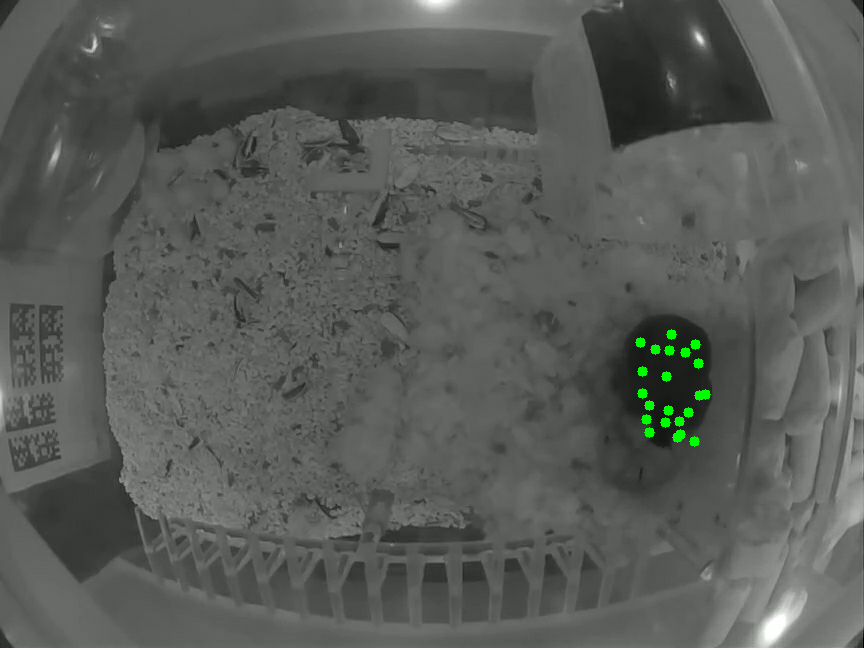

In [10]:
frame_with_keypoints = draw_keypoints(ex)
px.imshow(frame_with_keypoints)

# Multiple-view keypoints

In [16]:
mv_base_dir='/path/to/downloaded/mutliview/'

In [43]:
with tf.io.gfile.GFile(os.path.join(mv_base_dir, 'keypoints.csv'), 'r') as f:
  df_mv=pd.read_csv(f)

In [44]:
df_mv.head(1)

FRAME  LEFT_EAR_X  ...  TIP_TAIL_X  TIP_TAIL_Y
0  view0_0057.png       325.0  ...       242.2       322.5

[1 rows x 35 columns]

In [40]:
def draw_multiview_keypoints(df_mv_frames, row):

  frame_name = df_mv_frames.loc[row, 'FRAME']
  with tf.io.gfile.GFile(os.path.join(mv_base_dir, frame_name), 'rb') as f:
    frame = cv2.imdecode(np.frombuffer(f.read(), dtype=np.uint8), cv2.IMREAD_COLOR)

  for k in keypoint_names:
    x_name=f'{k}_X'
    y_name=f'{k}_Y'
    try:
      kp_x = int(df_mv_frames.loc[row, x_name])
      kp_y = int(df_mv_frames.loc[row, y_name])
      cv2.circle(frame, (kp_x,kp_y), 5, (0,255,0), -1)
    except KeyError:
      pass
  return frame

In [45]:
mv_frame = draw_multiview_keypoints(df_mv, 50)


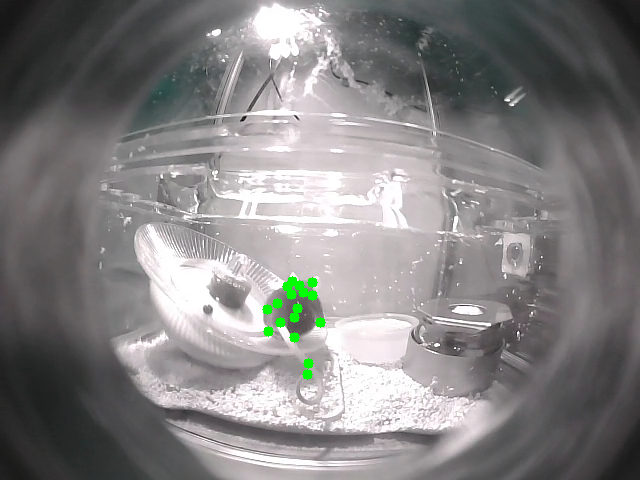

In [46]:
px.imshow(mv_frame)